In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *

cupyon=True

try:
    import numpy as np

    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    import numpy as np
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


cupy not installed. Using numpy.
Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077
cupy not installed. Using numpy.


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 30*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -10*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 10*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 1000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")

Tweezer starting positions: -10.0 microns or -1.133786848072562 MHz
Tweezer ending positions: 10.0 microns or 1.133786848072562 MHz
One micron corresponds to 0.1133786848072586 MHz


In [4]:
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_linearramp(globalvariables)
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)


optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, True)
forces = retrieveforces(AWGinitguesscosine, globalvariables, 1, True)
initial_x_dx= initdistribution_MaxwellBoltzmann(num_particles, 40e-6, 1e-8, atommass, globalvariables)



# Mid-code visualizations
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())


# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [5]:
forces = retrieveforces_idealconditions(AWGinitguesscosine, optimized_position,globalvariables)

In [6]:
forces_notideal = retrieveforces(AWGinitguesscosine, globalvariables, 1, False)


In [7]:
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, False)

In [8]:
potentials_ideal = retrievepotentials_idealconditions(AWGinitguesscosine, optimized_position, globalvariables)

In [9]:
rescalingfac = np.max(np.gradient(potentials_ideal[0])) / np.max(gradient(potentials[0]))

In [10]:
rescalingfac2 = np.max((potentials_ideal[0])) / np.max((potentials[0]))

In [11]:
rescalingfac2*potentials[0]

array([1.03532719e-26, 1.37866801e-25, 4.48993935e-25, ...,
       7.69488930e-25, 4.48993935e-25, 1.37866801e-25])

In [12]:
potentials[0]

array([9.68259065e-34, 1.28935839e-32, 4.19908269e-32, ...,
       7.19641713e-32, 4.19908269e-32, 1.28935839e-32])

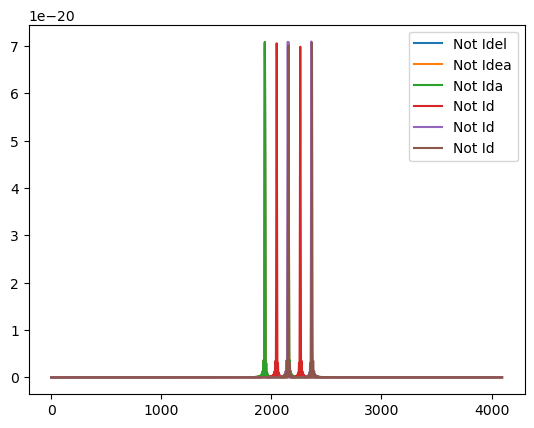

In [13]:
plt.plot(tonumpy(potentials[0]*rescalingfac2), label='Not Idel')
plt.plot(tonumpy(potentials[1800]*rescalingfac2), label='Not Idea')
plt.plot((potentials_ideal[0]), label='Not Ida')
plt.plot((potentials_ideal[900]), label='Not Id')
plt.plot((potentials_ideal[1600]), label='Not Id')
plt.plot((potentials_ideal[1700]), label='Not Id')

plt.legend()

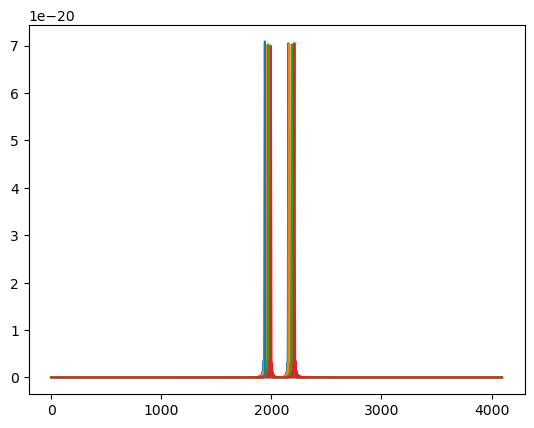

In [14]:
plt.plot(tonumpy(potentials_ideal[0]), label='Not Idel')
plt.plot(tonumpy(potentials_ideal[200]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[450]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[600]), label='Not Idel')

plt.vlines(x =find_max_peak_location((tonumpy(potentials_ideal[0]))), ymin = 0, ymax = np.max(tonumpy(potentials[0]*rescalingfac2)))


In [15]:
positionstofourier(50e-6, 0, globalvariables)

(2583.845107273679, 0)

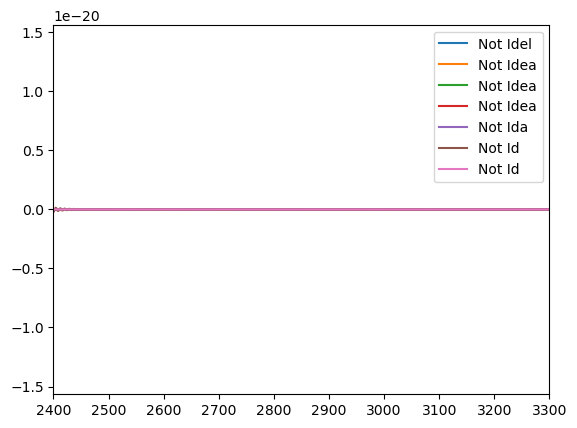

In [17]:
plt.plot(gradient(potentials[500])*rescalingfac, label='Not Idel')
plt.plot(gradient(potentials[1800])*rescalingfac, label='Not Idea')
plt.plot(gradient(potentials[0])*rescalingfac, label='Not Idea')
plt.plot(gradient(potentials[900])*rescalingfac, label='Not Idea')

plt.plot(np.gradient(potentials_ideal[500]), label='Not Ida')
plt.plot(np.gradient(potentials_ideal[1800]), label='Not Id')
plt.plot(np.gradient(potentials_ideal[0]), label='Not Id')

plt.xlim(2400,3300)

plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


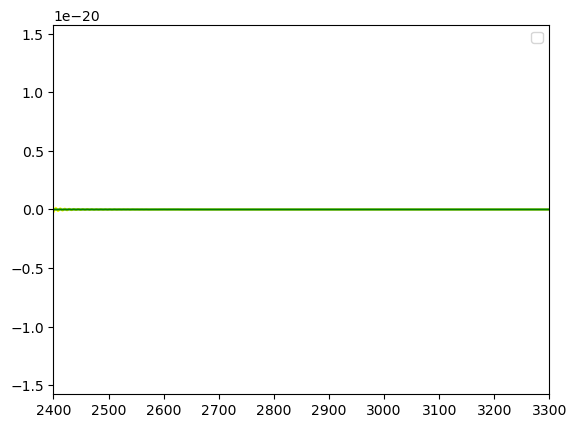

In [20]:

plt.plot(forces[-1], color='yellow')
plt.plot(forces_notideal[-1], color='green')
plt.xlim(2400,3300)


plt.legend()

In [ ]:
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[3000:3500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())
# plt.xlim(2400,2900)

# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [21]:
from aodfunctions.general import *

In [24]:
# movetimes = np.arange(75,150,5)*10**(-6)
# movetemperatures = np.array([1])*10**(-6)

movetimes = np.array([100,200])*10**(-6)
movetemperatures = np.array([1])*10**(-6)


ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "Linear", 1, globalvariables)
notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "Linear", 1, globalvariables)
idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "SinSq", 1, globalvariables)


1.394192245009825e-20
2583.9431659582037
1.4015809162450468e-20
2583.896111129864
5.957652402216689e-22
2583.9431659582037
1.5504692498443971e-21
2583.896111129864
1.40207706805857e-20
2583.9431659582265
1.388469557897586e-20
2583.896111129851
3.0206691623602626e-22
2583.9431659582265
6.999587980582345e-22
2583.896111129851


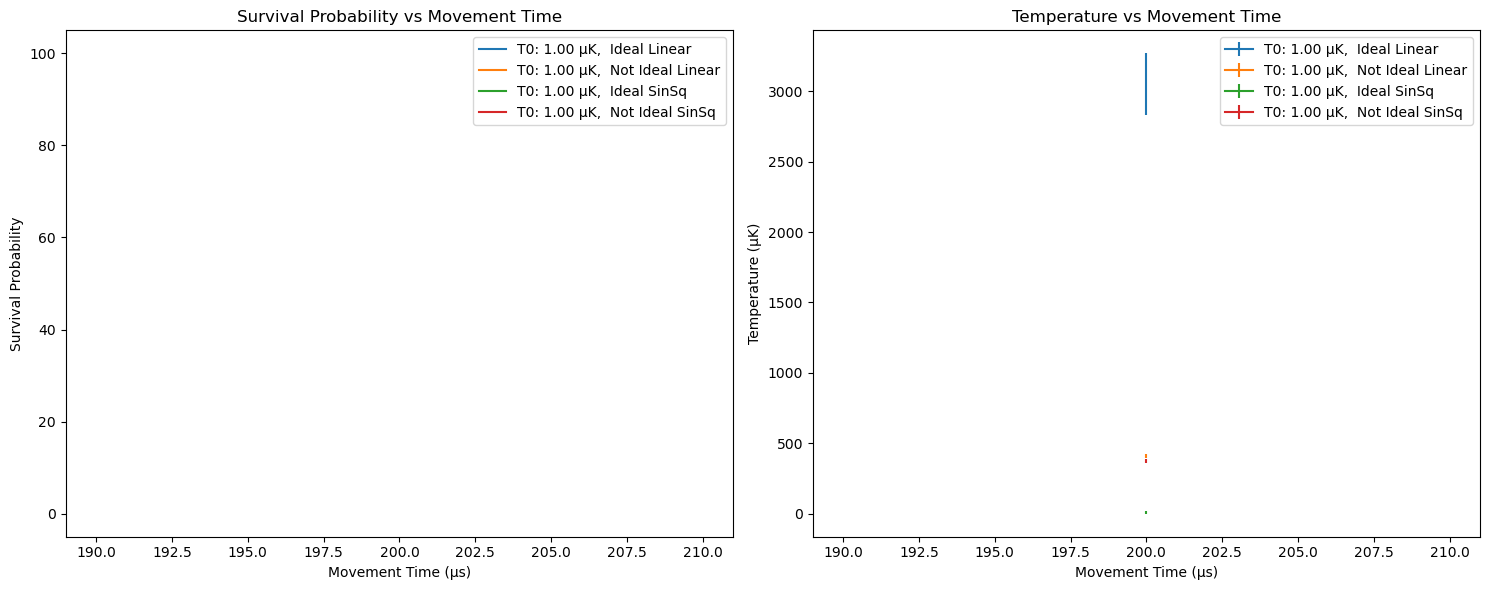

In [23]:
plots_fixeddistance_multipleanalysis(movetimes, movetemperatures, np.array([ideallinear, notideallinear, idealsinsq, notidealsinsq]), np.array(["Ideal Linear", "Not Ideal Linear", "Ideal SinSq", "Not Ideal SinSq"]))

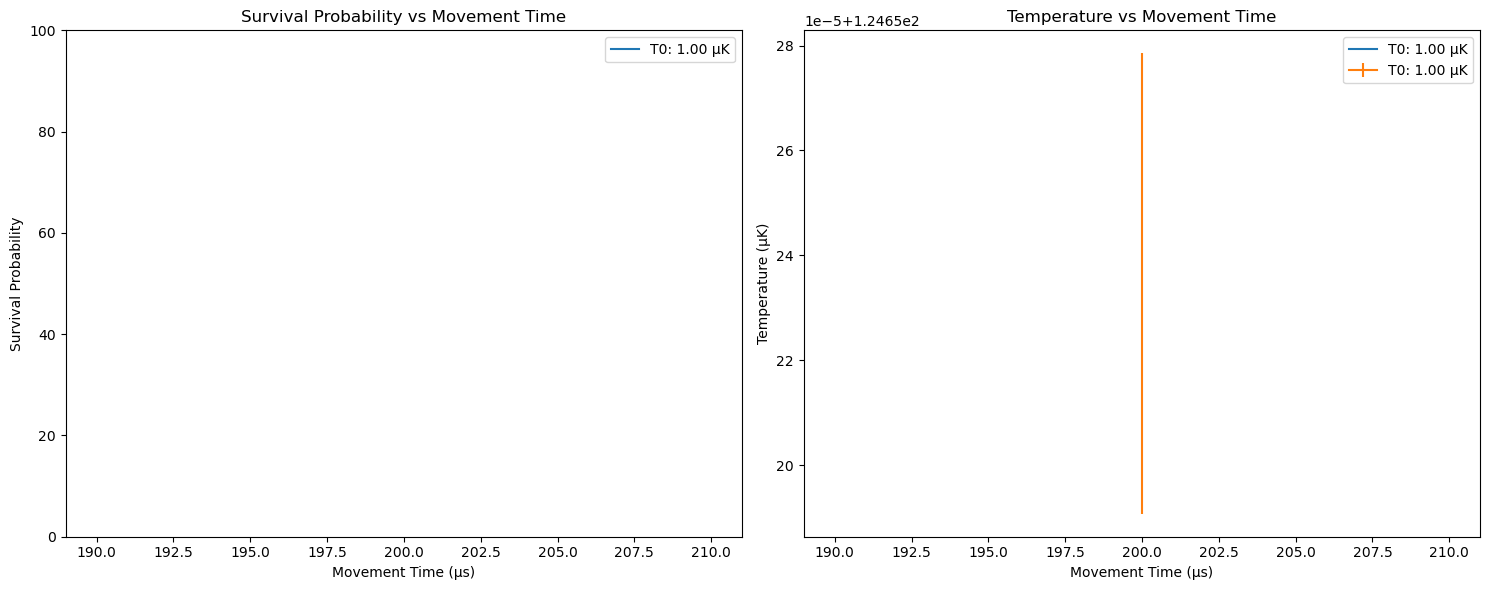

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, ideallinear)

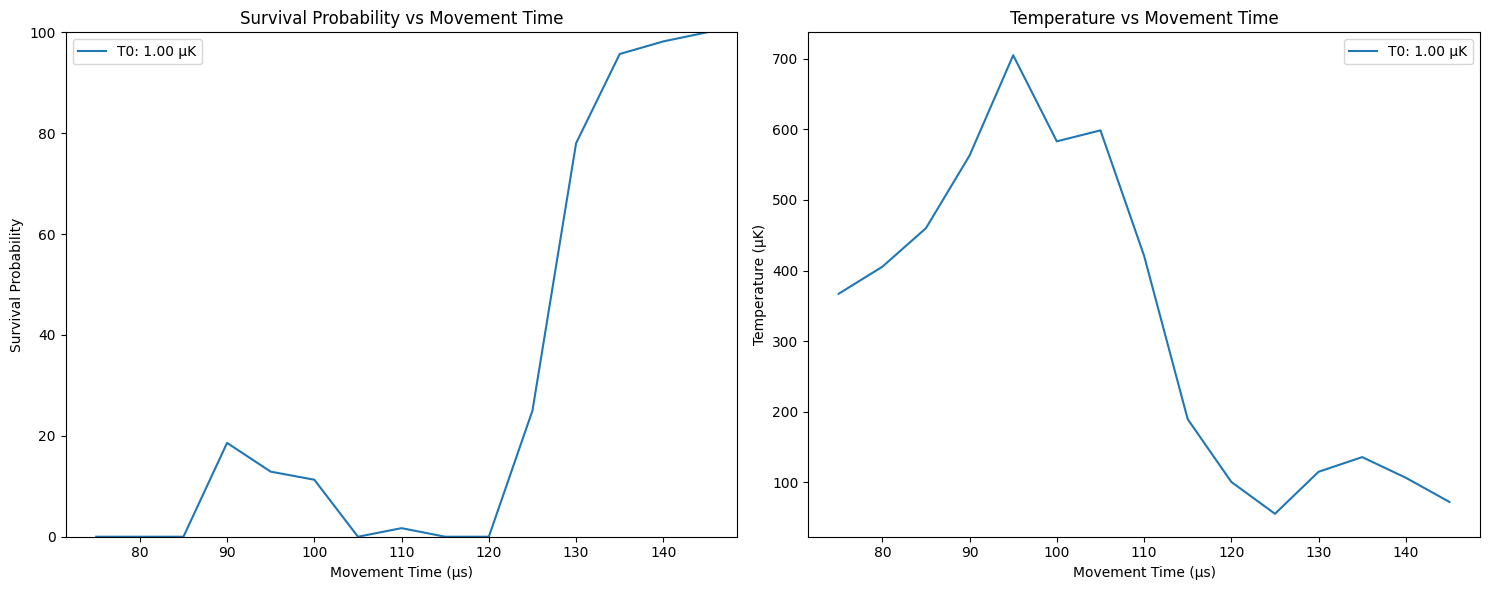

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, notideallinear)

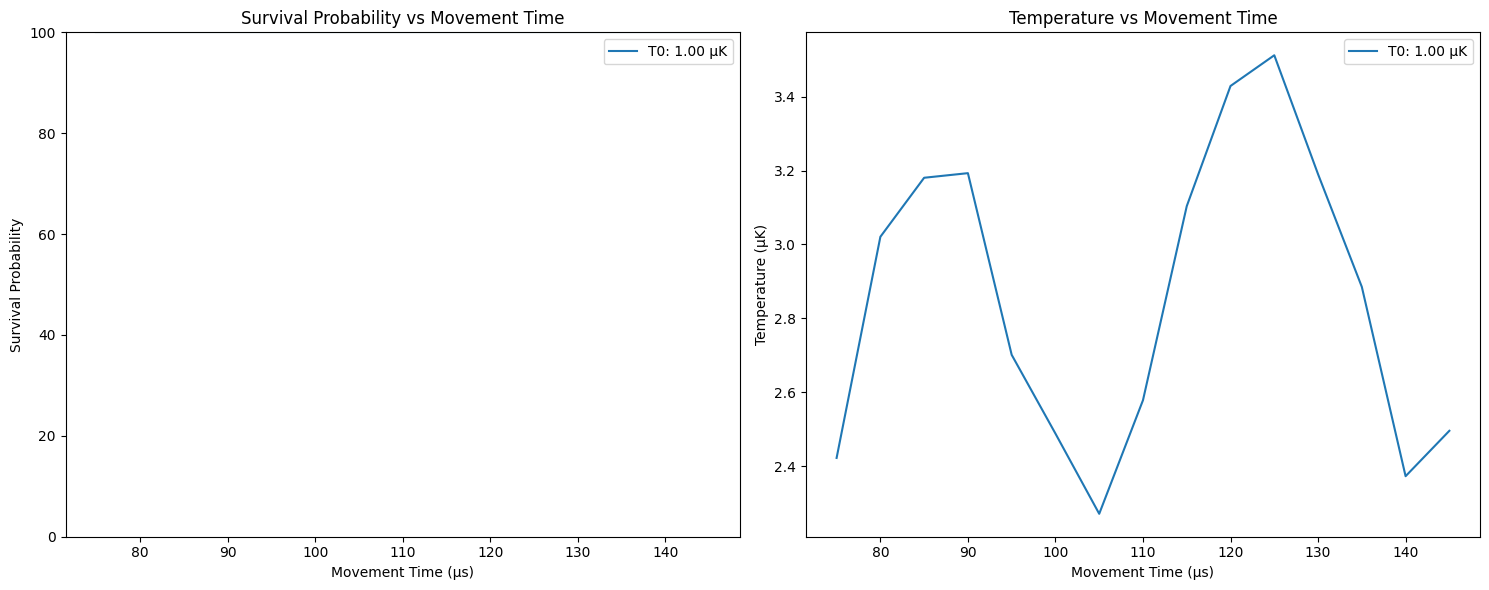

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, idealsinsq)

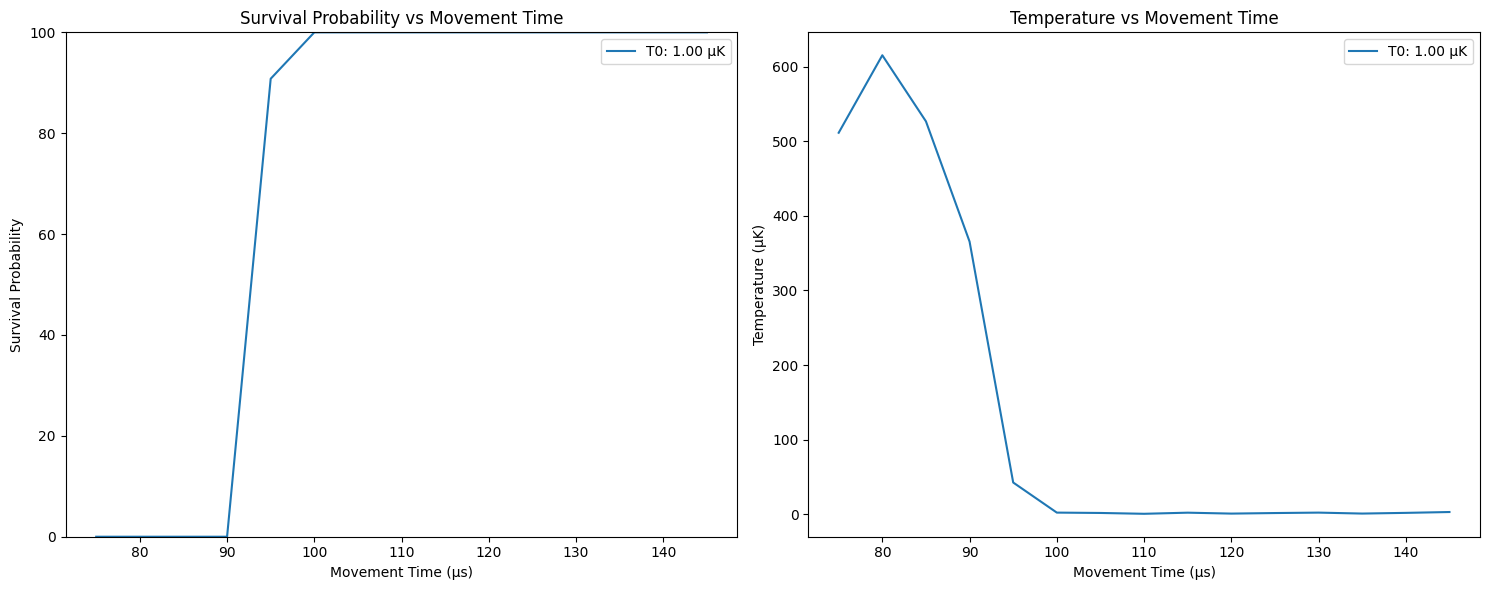

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, notidealsinsq)

In [ ]:
from numpy.polynomial.legendre import legval

def constructamplitudes(amplitudes, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    amplitudes = tonumpy(amplitudes)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, amplitudes)
    
    return tocupy(constructed_values)

def constructphases(phases, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    phases = tonumpy(phases)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, phases)
    
    return tocupy(constructed_values)

def constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables

    for i in range(len(frequencies)):
        amplitudeprofile = constructamplitudes(amplitudes[i], optimizationspace)
        phaseprofile = constructphases(phases[i], optimizationspace)
        constructedwaveform += amplitudeprofile[i] * np.cos(2*np.pi*frequencies[i]*optimizationspace + phaseprofile[i])
    
    return tocupy(constructedwaveform)

def init_opt_waveformfitFourierVariant(AWGinitguess,freqres, ampres, phaseres, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = cp.zeros(len(AWGinitguess))
    AWGwaveform[0:numpix_frame] = AWGinitguess[0:numpix_frame]
    AWGwaveform[-numpix_frame:] = AWGinitguess[-numpix_frame:]
    
    optimizationsection = AWGinitguess[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(0,1, len(AWGinitguess) - 2*numpix_frame)
    
    
    frequencies = cp.zeros(freqres) # in units of pixels
    amplitudes = cp.zeros((freqres, ampres)) # arbitrary units
    phases = cp.zeros((freqres, phaseres)) # in units of pixels
    
    
    constructedwaveform = constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables )
    
    
    opt_amplitudes, opt_phases = 
    
    optimizedwaveform = constructFourierVariant(optimizationspace, frequencies, opt_amplitudes, opt_phases, globalvariables )
    
    AWGwaveform[numpix_frame:-numpix_frame] = optimizedwaveform

    return AWGwaveform


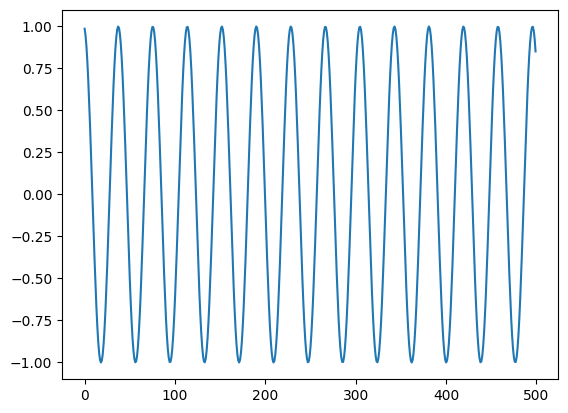

In [ ]:
plt.plot(AWGinitguesscosine.get()[0:500])

1940.8309785452643


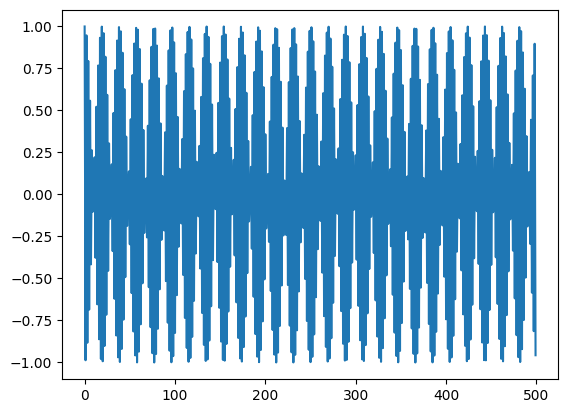

In [ ]:
testrange = np.linspace(0,1*len(AWGinitguesscosine) / numpix_real,len(AWGinitguesscosine))
frequency1 = positionstofourier(-10e-6, 0, globalvariables)[0]
print(frequency1)
test = np.cos(2*np.pi*frequency1*testrange)

plt.plot(test[0:500])

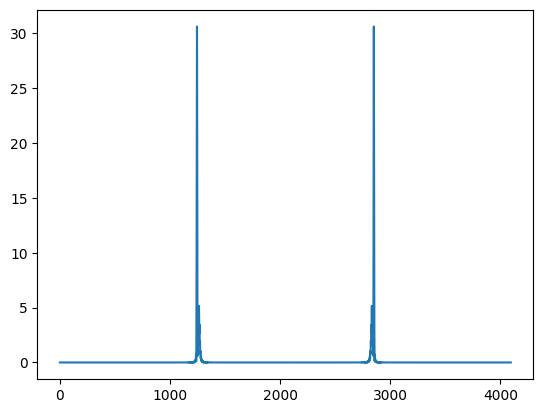

In [ ]:
plt.plot(potentials[-400].get())




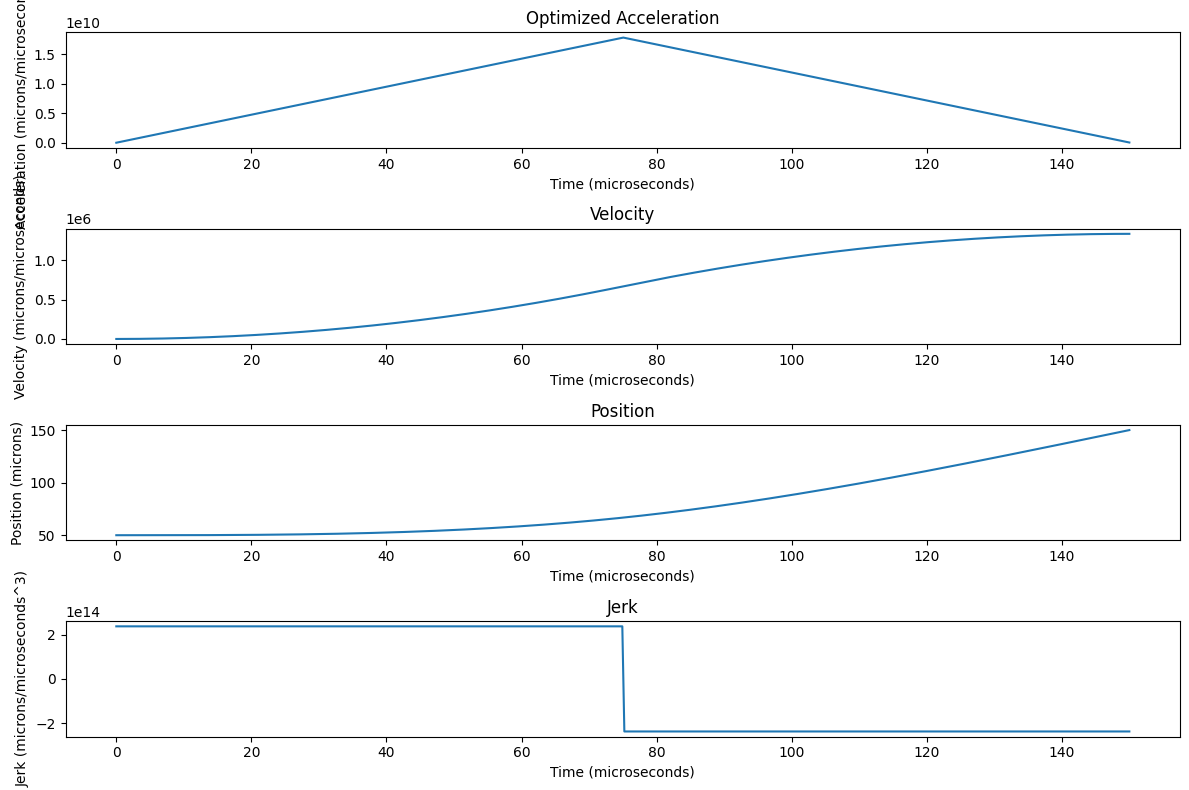

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()